# Find sentiment for a ticker via 10Q filings

### Start

In [ ]:
import os, re, json, math, time, requests, numpy as np, pandas as pd
from bs4 import BeautifulSoup
import warnings
from bs4.builder import XMLParsedAsHTMLWarning
from datetime import datetime, timezone, timedelta
from dotenv import load_dotenv

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from sentence_transformers import SentenceTransformer  # optional (we won't persist embeddings here)

import json
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

# -----------------------
# CONFIG
# -----------------------
FINBERT = "yiyanghkust/finbert-tone"
AV_BASE = "https://www.alphavantage.co/query"
def SEC_HEADERS(host: str | None = None):
    h = {
        "User-Agent": f"Severin Spagnola (contact: {os.getenv('SEC_EMAIL','severin.spagnola@sjsu.edu')})",
        "Accept-Encoding": "gzip, deflate",
    }
    # Only set Host if you explicitly pass one (you usually don't need to)
    if host:
        h["Host"] = host
    return h

load_dotenv()

False

In [6]:
def load_finbert():
    tok = AutoTokenizer.from_pretrained(FINBERT)
    mdl = AutoModelForSequenceClassification.from_pretrained(FINBERT)
    pipe = TextClassificationPipeline(model=mdl, tokenizer=tok, return_all_scores=True, truncation=True)
    return pipe

def finbert_scores(texts, pipe, max_len=512, batch=16):
    out = []
    for i in range(0, len(texts), batch):
        preds = pipe(texts[i:i+batch], max_length=max_len)
        for row in preds:
            d = {x["label"].lower(): x["score"] for x in row}
            out.append({"pos": d.get("positive",0.0), "neu": d.get("neutral",0.0), "neg": d.get("negative",0.0)})
    return out

# -----------------------
# SEC helpers
# -----------------------
def get_cik(ticker:str) -> str:
    """Return zero-padded CIK string for a ticker."""
    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK0000320193.json"  # known-good to check headers
    # quick ping to ensure headers are ok
    try:
        _ = requests.get(url, headers=SEC_HEADERS(), timeout=10)
    except Exception:
        pass
    # submissions endpoint (reliable for cik)
    url = f"https://data.sec.gov/submissions/CIK{str(0).zfill(10)}.json"  # dummy shape
    # real mapping endpoint:
    # We can call the "company_tickers.json" mapping once and cache
    map_url = "https://www.sec.gov/files/company_tickers.json"
    r = requests.get(map_url, headers=SEC_HEADERS(), timeout=30)  # no forced Host
    r.raise_for_status()
    data = r.json()
    t = ticker.upper()
    for _, rec in data.items():
        if rec.get("ticker","").upper() == t:
            return str(rec["cik_str"]).zfill(10)
    raise ValueError(f"CIK not found for ticker {ticker}")

def list_recent_10q(cik:str, count:int=2):
    """Return recent 10-Q (accession, primaryDoc) tuples."""
    url = f"https://data.sec.gov/submissions/CIK{cik}.json"
    r = requests.get(url, headers=SEC_HEADERS(), timeout=30)
    r.raise_for_status()
    js = r.json()
    forms = js.get("filings",{}).get("recent",{})
    out = []
    for form, acc, prim in zip(forms.get("form",[]),
                               forms.get("accessionNumber",[]),
                               forms.get("primaryDocument",[])):
        if form == "10-Q":
            out.append((acc.replace("-",""), prim))
        if len(out) >= count:
            break
    return out

def fetch_filing_html(cik:str, accession:str, primary:str) -> str:
    """Download the primary 10-Q html text."""
    base = f"https://www.sec.gov/Archives/edgar/data/{int(cik)}/{accession}"
    url  = f"{base}/{primary}"
    r = requests.get(url, headers=SEC_HEADERS(), timeout=60)
    r.raise_for_status()
    return r.text

SECTION_PATTERNS = [
    (r"item\s+2\.\s*management[’']?s discussion and analysis.*?(?=item\s+3\.)", "MD&A"),
    (r"item\s+1a\.\s*risk factors.*?(?=item\s+2\.)", "RiskFactors"),
    (r"item\s+1\.\s*financial statements.*?(?=item\s+2\.)", "FinancialStatementsNarrative"),
    (r"overview.*?(?=results of operations|liquidity|capital resources|risk factors|item\s+\d)", "Overview"),
]
def _make_soup(html: str) -> BeautifulSoup:
    # Try fast/forgiving parsers in order; fall back to stdlib
    for parser in ("lxml", "html5lib", "html.parser"):
        try:
            return BeautifulSoup(html, parser)
        except Exception:
            continue
    # If everything failed, raise the last error
    return BeautifulSoup(html, "html.parser")

def extract_sections(html:str) -> dict:
    soup = _make_soup(html)
    # get text-y version
    txt = soup.get_text("\n", strip=True)
    # normalize whitespace and lowercase copy for regex
    low = re.sub(r"[ \t]+"," ", txt.lower())
    sections = {}
    for pat, name in SECTION_PATTERNS:
        m = re.search(pat, low, flags=re.S)
        if m:
            # map back to original text slice by proportions (approx); or just grab substring from low
            seg_low = low[m.start():m.end()]
            # find the same slice in the original (simple fallback)
            # For robustness, just return the lowercased slice (still fine for sentiment)
            sections[name] = seg_low[:200000]  # cap to avoid giant walls
    # if no sections, fall back to whole doc truncated
    if not sections:
        sections["FullDocument"] = low[:200000]
    return sections

# -----------------------
# XBRL (US-GAAP) Facts  — consistent TTM from quarterly items
# -----------------------
PREF = {
    "revenue": [
        "RevenueFromContractWithCustomerExcludingAssessedTax",
        "SalesRevenueNet",
        "Revenues",
    ],
    "net_income": ["NetIncomeLoss"],
    "eps_diluted": ["EarningsPerShareDiluted"],
    "diluted_shares": [
        "WeightedAverageNumberOfDilutedSharesOutstanding",
        "WeightedAverageNumberOfDilutedSharesOutstandingBasic",
    ],
    "cfo": ["NetCashProvidedByUsedInOperatingActivities"],
    "capex": [
        "PaymentsToAcquirePropertyPlantAndEquipment",
        "PaymentsToAcquireProductiveAssets",
    ],
}

def _pick_latest(values, form_types=None):
    """Pick the most recent value (by end date) optionally filtering form types."""
    if not values: return None
    rows = []
    for v in values:
        if form_types and v.get("form") not in form_types:  # e.g., '10-Q' or '10-K'
            continue
        try:
            end = datetime.fromisoformat(v["end"])
        except Exception:
            continue
        val = v.get("val")
        if val is None: continue
        rows.append((end, float(val)))
    if not rows: return None
    rows.sort(key=lambda x: x[0], reverse=True)
    return rows[0][1]

def get_company_facts(cik:str) -> dict:
    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json"
    r = requests.get(url, headers=SEC_HEADERS(), timeout=30)
    r.raise_for_status()
    return r.json()

def _select_quarterly(facts, tag, unit):
    if tag not in facts: return []
    return [
        x for x in facts[tag]["units"].get(unit, [])
        if (x.get("fp") in ("Q1","Q2","Q3","Q4") or x.get("qtrs") == 1)
    ]

def _ttm_sum(items):
    """Sum last 4 quarterly values."""
    if not items: return None
    rows = []
    for it in items:
        end = it.get("end")
        val = it.get("val")
        if end and val is not None:
            try:
                rows.append((datetime.fromisoformat(end), float(val)))
            except Exception:
                pass
    rows.sort(key=lambda x: x[0])
    vals = [v for _, v in rows[-4:]]
    return float(np.nansum(vals)) if vals else None

def _avg_last4(items):
    """Average last 4 quarterly values (for diluted shares)."""
    if not items: return None
    rows = []
    for it in items:
        end = it.get("end")
        val = it.get("val")
        if end and val is not None:
            try:
                rows.append((datetime.fromisoformat(end), float(val)))
            except Exception:
                pass
    rows.sort(key=lambda x: x[0])
    vals = [v for _, v in rows[-4:]]
    return float(np.nanmean(vals)) if vals else None

def build_ttm_metrics(facts_json: dict) -> dict:
    facts = facts_json.get("facts", {}).get("us-gaap", {})
    # series
    rev_q   = None; ni_q = None; eps_q = None; sh_q = None; cfo_q = None; capex_q = None
    for tag in PREF["revenue"]:
        rev_q = _select_quarterly(facts, tag, "USD") or rev_q
    ni_q    = _select_quarterly(facts, "NetIncomeLoss", "USD")
    for tag in PREF["eps_diluted"]:
        eps_q = _select_quarterly(facts, tag, "USD/shares") or eps_q
    for tag in PREF["diluted_shares"]:
        sh_q  = _select_quarterly(facts, tag, "shares") or sh_q
    for tag in PREF["cfo"]:
        cfo_q = _select_quarterly(facts, tag, "USD") or cfo_q
    for tag in PREF["capex"]:
        capex_q = _select_quarterly(facts, tag, "USD") or capex_q

    revenue_ttm   = _ttm_sum(rev_q)
    net_income_ttm= _ttm_sum(ni_q)
    eps_ttm       = _ttm_sum(eps_q)          # sum quarterly EPS
    diluted_sh_ttm= _avg_last4(sh_q)         # average WA diluted shares
    cfo_ttm       = _ttm_sum(cfo_q)
    capex_ttm     = _ttm_sum(capex_q)
    fcf_ttm       = (cfo_ttm or 0.0) - abs(capex_ttm or 0.0)

    # sanity: NI ≈ EPS * Shares (within tolerance)
    if eps_ttm and diluted_sh_ttm and net_income_ttm:
        approx = eps_ttm * diluted_sh_ttm
        if abs(approx - net_income_ttm)/max(1.0, net_income_ttm) > 0.15:
            print("[warn] EPS*Shares != NetIncome by >15%. Check tags/periods.")

    return dict(
        revenue_ttm=revenue_ttm,
        net_income_ttm=net_income_ttm,
        eps_diluted_ttm=eps_ttm,
        diluted_shares_ttm=diluted_sh_ttm,
        cfo_ttm=cfo_ttm,
        capex_ttm=capex_ttm,
        fcf_ttm=fcf_ttm,
        rev_per_share=(revenue_ttm / diluted_sh_ttm) if (revenue_ttm and diluted_sh_ttm) else None,
    )


### Valuation

In [7]:
# -----------------------
# Alpha Vantage price
# -----------------------
def latest_price(ticker:str):
    key = os.getenv("ALPHAVANTAGE_API_KEY")
    if not key:
        return None
    params = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",
        "symbol": ticker.upper(),
        "apikey": key,
        "outputsize": "compact",
    }
    r = requests.get(AV_BASE, params=params, timeout=30)
    try:
        js = r.json()
        ts = js["Time Series (Daily)"]
        dates = sorted(ts.keys(), reverse=True)
        last = float(ts[dates[0]]["5. adjusted close"])
        return last
    except Exception:
        return None

# -----------------------
# Valuation: sector-aware multiples + conservative DCF
# -----------------------
SECTOR_MULTIPLES = {
    "Industrials": {"PE": 12.0, "PS": 1.2},
    "Consumer Discretionary": {"PE": 15.0, "PS": 1.5},
    "Technology": {"PE": 30.0, "PS": 6.8},
    "_default": {"PE": 18.0, "PS": 2.5},
}

def multiples_anchor(metrics:dict, sector="Technology"):
    cfg = SECTOR_MULTIPLES.get(sector, SECTOR_MULTIPLES["_default"])
    eps = metrics.get("eps_diluted_ttm")
    rps = metrics.get("rev_per_share")
    pe_anchor = eps * cfg["PE"] if eps else None
    ps_anchor = rps * cfg["PS"] if rps else None
    anchors = [x for x in (pe_anchor, ps_anchor) if x is not None and math.isfinite(x)]
    mid = float(np.mean(anchors)) if anchors else None
    lo  = float(np.min(anchors)) if anchors else None
    hi  = float(np.max(anchors)) if anchors else None
    return {
        "pe_anchor": pe_anchor,
        "ps_anchor": ps_anchor,
        "fair_value_mid": mid,
        "fair_value_low": lo,
        "fair_value_high": hi,
        "assumptions": cfg,
    }

def dcf_anchor(metrics:dict, years=5, g=0.04, r=0.095, g_term=0.02):
    fcf0 = metrics.get("fcf_ttm")
    sh   = metrics.get("diluted_shares_ttm")
    if not fcf0 or not sh or sh <= 0:
        return None
    pv = 0.0
    fcf = fcf0
    for t in range(1, years+1):
        fcf *= (1+g)
        pv += fcf / ((1+r)**t)
    terminal = (fcf * (1+g_term)) / (r - g_term)
    pv_term = terminal / ((1+r)**years)
    return (pv + pv_term) / sh

def blended_fair_value(mult_mid, dcf_val, w=0.5):
    if mult_mid is None and dcf_val is None:
        return None
    if mult_mid is None: return dcf_val
    if dcf_val  is None: return mult_mid
    return w*mult_mid + (1-w)*dcf_val

# -----------------------
# 10-Q pipeline
# -----------------------
def analyze_10q(ticker: str, quarters: int = 1, sector: str | None = None):
    cik = get_cik(ticker)
    pairs = list_recent_10q(cik, count=max(1, quarters))
    if not pairs:
        raise RuntimeError("No 10-Q filings found.")
    # download and parse sections from each 10-Q
    docs = []
    for acc, prim in pairs:
        html = fetch_filing_html(cik, acc, prim)
        secs = extract_sections(html)
        docs.append({"accession": acc, "primary": prim, "sections": secs})
        time.sleep(0.3)  # be nice

    # sentiment per section
    pipe = load_finbert()
    summary = []
    for doc in docs:
        for name, text in doc["sections"].items():
            sc = finbert_scores([text], pipe)[0]
            summary.append({
                "ticker": ticker.upper(),
                "accession": doc["accession"],
                "section": name,
                "pos": sc["pos"], "neu": sc["neu"], "neg": sc["neg"],
                "sent_score": sc["pos"] - sc["neg"]
            })
    sent_df = pd.DataFrame(summary).sort_values(["accession","section"])

    # fundamentals (TTM) + price + fair value (multiples + DCF + blend)
    facts  = get_company_facts(cik)
    gaap   = build_ttm_metrics(facts)
    price  = latest_price(ticker)

    # NEW: decide sector (fallback to "_default" if unknown)
    sector_name = (sector or "_default")

    # CHANGE THIS LINE:
    mult   = multiples_anchor(gaap, sector=sector_name)  # was sector="Technology"
    
    dcfval = dcf_anchor(gaap, years=5, g=0.04, r=0.095, g_term=0.02)
    blended= blended_fair_value(mult.get("fair_value_mid"), dcfval, w=0.5)
    value  = {
        **mult,
        "dcf_anchor": round(dcfval,2) if dcfval else None,
        "fair_value_blend": round(blended,2) if blended else None,
        "current_price": price,
    }
    if price and blended:
        value["upside_pct"] = 100.0*(blended/price - 1.0)

    return {
        "ticker": ticker.upper(),
        "cik": cik,
        "sentiment": sent_df,
        "gaap_ttm": gaap,
        "valuation": value,
        "filings": [{"accession": d["accession"], "primary": d["primary"]} for d in docs],
    }

### Test the code

Analyzing LEG …


Device set to use mps:0
/Users/severinspagnola/Desktop/project-fa25-QVP/venv/lib/python3.13/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


,ticker,accession,section,pos,neu,neg,sent_score
0,LEG,000005849225000458,FinancialStatementsNarrative,0.000002,0.999997,0.000001,5.825858e-07
1,LEG,000005849225000458,MD&A,0.000245,0.999731,0.000024,2.207216e-04
2,LEG,000005849225000458,RiskFactors,0.066693,0.365419,0.567888,-5.011941e-01


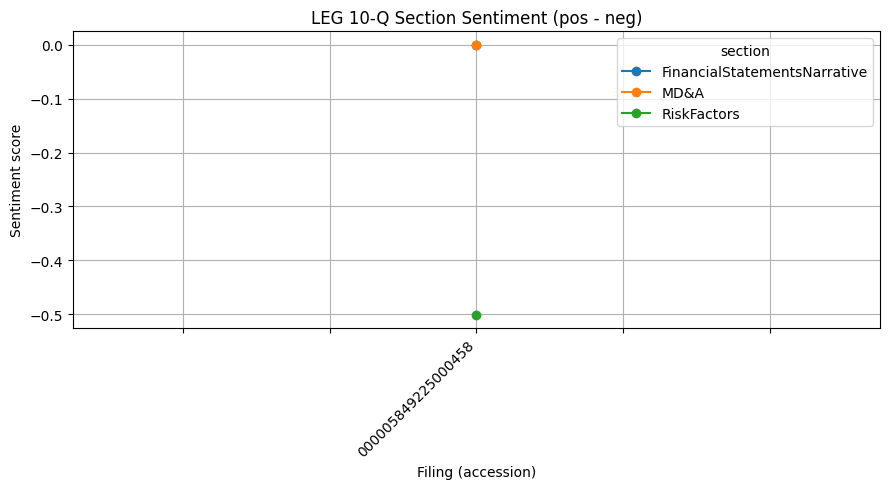

Done. Files saved:  ['sentiment_LEG.csv', 'valuation_LEG.json', 'sentiment_trend_LEG.csv']


In [10]:
# ---- choose your ticker(s) and how many recent 10-Qs to analyze
TICKERS = ["LEG"]          # add more like ["AAPL","MSFT"] to loop
QUARTERS = 1                # analyze up to 4 most recent 10-Qs (if available)

SECTOR_BY_TICKER = {
    "LEG": "Industrials",
}

all_sent = []
all_meta = []

for t in TICKERS:
    print(f"Analyzing {t} …")
    res = analyze_10q(t, quarters=QUARTERS, sector=SECTOR_BY_TICKER.get(t, "_default"))

    # sentiment table (per filing section)
    sent = res["sentiment"].copy()
    sent["ticker"] = t
    all_sent.append(sent)

    # quick valuation snapshot
    meta = {
        "ticker": t,
        "cik": res["cik"],
        "gaap_ttm": res["gaap_ttm"],
        "valuation": res["valuation"],
        "filings": res["filings"],
    }
    all_meta.append(meta)

    # ---- save artifacts
    sent.to_csv(f"sentiment_{t}.csv", index=False)
    with open(f"valuation_{t}.json","w") as f:
        json.dump(meta, f, indent=2)

# ---- combine sentiment across tickers for convenience
sent_df = pd.concat(all_sent, ignore_index=True) if all_sent else pd.DataFrame()
display(sent_df.head(20))  # quick peek

# ---- Plot sentiment trend (pos-neg) by section across the last filings of the first ticker
if not sent_df.empty:
    tt = TICKERS[0]
    sdf = sent_df[sent_df["ticker"] == tt].copy()

    # make accession order chronological by string (works fine for accessions) and pivot
    sdf = sdf.sort_values(["accession","section"])
    pivot = sdf.pivot_table(index="accession", columns="section", values="sent_score", aggfunc="mean")

    # line plot
    ax = pivot.plot(marker="o", figsize=(9,5))
    ax.set_title(f"{tt} 10-Q Section Sentiment (pos - neg)")
    ax.set_xlabel("Filing (accession)")
    ax.set_ylabel("Sentiment score")
    ax.grid(True)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # also save the pivot to CSV for later comparisons
    pivot.to_csv(f"sentiment_trend_{tt}.csv")

print("Done. Files saved: ",
      [f"sentiment_{t}.csv" for t in TICKERS] +
      [f"valuation_{t}.json" for t in TICKERS] +
      ([f"sentiment_trend_{TICKERS[0]}.csv"] if TICKERS else []))
